In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import colors
from eofs.xarray import Eof
import tensorflow as tf
import gpflow
from esem import gp_model
import seaborn as sns
import cartopy.crs as ccrs
from utils import *

2024-03-05 01:45:01.764965: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-05 01:45:01.765048: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-05 01:45:01.766085: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-05 01:45:01.772660: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-05 01:45:02.482406: W tensorflow/compiler/tf2

### Prepare data

In [2]:
# List of dataset to use for training
train_files = ["ssp126", "ssp370", "ssp585", "historical", "hist-GHG"]

In [3]:
# Create training and testing arrays
X_train, eof_solvers = create_predictor_data(train_files)
y_train_dtr = create_predictdand_data(train_files)['diurnal_temperature_range'].values.reshape(-1, 96 * 144)

X_test = get_test_data('ssp245', eof_solvers)
Y_test = xr.open_dataset(data_path + 'outputs_ssp245.nc').compute()
dtr_truth = Y_test["diurnal_temperature_range"].mean('member')

In [4]:
# Drop rows including nans
nan_train_mask = X_train.isna().any(axis=1).values
X_train = X_train.dropna(axis=0, how='any')
y_train_dtr = y_train_dtr[~nan_train_mask]
assert len(X_train) == len(y_train_dtr)

nan_test_mask = X_test.isna().any(axis=1).values
X_test = X_test.dropna(axis=0, how='any')
dtr_truth = dtr_truth[~nan_test_mask]

In [5]:
# Standardize predictor fields requiring standardization (non-EOFs)
train_CO2_mean, train_CO2_std = X_train['CO2'].mean(), X_train['CO2'].std()
train_CH4_mean, train_CH4_std = X_train['CH4'].mean(), X_train['CH4'].std()

X_train.CO2 = (X_train.CO2 - train_CO2_mean) / train_CO2_std
X_train.CH4 = (X_train.CH4 - train_CH4_mean) / train_CH4_std

X_test.CO2 = (X_test.CO2 - train_CO2_mean) / train_CO2_std
X_test.CH4 = (X_test.CH4 - train_CH4_mean) / train_CH4_std

In [6]:
# Standardize predictand fields
train_dtr_mean, train_dtr_std = y_train_dtr.mean(), y_train_dtr.std()
y_train_dtr = (y_train_dtr - train_dtr_mean) / train_dtr_std

### Prepare model

In [7]:
import gpflow
from gpflow.utilities import to_default_float
from gpflow.optimizers import Scipy
from gpflow.mean_functions import Constant
from gpflow.kernels import Matern52
from gpflow.utilities import print_summary

In [8]:
def create_feature_extractor(input_dim, output_dim):
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(input_dim,)),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(output_dim, activation='linear'),
        tf.keras.layers.Lambda(lambda x: tf.cast(x, tf.float64))
    ])
    return model


In [9]:
class DeepKernel(gpflow.kernels.Kernel):
    def __init__(self, feature_extractor, base_kernel, input_dim):
        super().__init__()
        self.feature_extractor = feature_extractor
        self.base_kernel = base_kernel
        self.input_dim = input_dim

    def K(self, X, X2=None):
        # Transform X and X2 using the neural network
        X_transformed = self.feature_extractor(X)
        X2_transformed = self.feature_extractor(X2) if X2 is not None else X2
        # Compute the kernel using the transformed inputs
        return self.base_kernel(X_transformed, X2_transformed)

    def K_diag(self, X):
        X_transformed = self.feature_extractor(X)
        return self.base_kernel.K_diag(X_transformed)


In [10]:
# Define the neural network feature extractor
input_dim = X_train.shape[1]  # Number of features in X
output_dim = 24
feature_extractor = create_feature_extractor(input_dim, output_dim)

# Freeze the neural network layers to make them non-trainable in GPflow's optimization process
for layer in feature_extractor.layers:
    layer.trainable = True

# Define the base kernel and the deep kernel
kernel_CO2 = Matern52(active_dims=[0, 1], variance=1.0, lengthscales=2 * [1.])
kernel_CH4 = Matern52(active_dims=[2, 3], variance=1.0, lengthscales=2 * [1.])
kernel_BC = Matern52(active_dims=[4, 5, 6, 7, 8, 9, 10, 11, 12, 13], variance=1.0, lengthscales=10 * [1.])
kernel_SO2 = Matern52(active_dims=[14, 15, 16, 17, 18, 19, 20, 21, 22, 23], variance=1.0, lengthscales=10 * [1.])

kernel_matern12 = kernel_CO2 + kernel_CH4 + kernel_BC + kernel_SO2

base_kernel = kernel_matern12
deep_kernel = DeepKernel(feature_extractor=feature_extractor, base_kernel=base_kernel, input_dim=input_dim)

# Mean Function
mean_function = Constant()

# Create the GP model
model = gpflow.models.GPR(data=(X_train.astype(float), y_train_dtr.astype(float)), kernel=deep_kernel, mean_function=mean_function)

# Compile the TensorFlow model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

@tf.function
def optimization_step():
    with tf.GradientTape(watch_accessed_variables=False) as tape:
        tape.watch(model.trainable_variables)
        loss = -model.log_marginal_likelihood()
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss

2024-03-05 01:46:01.478017: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79084 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:01:00.0, compute capability: 8.0


In [11]:
tolerance = 1e-6  # Define tolerance
patience = 10  # Define patience

# Initialize variables for early stopping mechanism
best_loss = float('inf')
patience_counter = 0
max_iterations = 5000

# Training loop
for iteration in range(max_iterations):  # Number of optimization steps
    loss = optimization_step()

    # Early stopping logic
    if best_loss - loss < tolerance:
        patience_counter += 1
    else:
        patience_counter = 0
        best_loss = loss

    if patience_counter >= patience:
        print(f"Stopping training after {iteration + 1} iterations due to convergence.")
        break

2024-03-05 01:46:09.792734: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0xc084070
2024-03-05 01:46:09.897675: I external/local_xla/xla/service/service.cc:168] XLA service 0x14e5eed3b220 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-05 01:46:09.897719: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2024-03-05 01:46:09.904579: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-05 01:46:09.948354: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1709628370.097681  181168 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Stopping training after 219 iterations due to convergence.


### Predict on testing set

In [12]:
# predict
standard_posterior_mean, standard_posterior_var = model.predict_y(X_test.values)
posterior_mean = standard_posterior_mean * train_dtr_std + train_dtr_mean
posterior_std = np.sqrt(standard_posterior_var) * train_dtr_std

In [13]:
# put output back into xarray format for calculating RMSE/plotting
posterior_dtr = np.reshape(posterior_mean, [86, 96, 144])
posterior_dtr_std = np.reshape(posterior_std, [86, 96, 144])

posterior_dtr_data = xr.DataArray(posterior_dtr, dims=dtr_truth.dims, coords=dtr_truth.coords)
posterior_dtr_std_data = xr.DataArray(posterior_dtr_std, dims=dtr_truth.dims, coords=dtr_truth.coords)

[Text(0.5, 1.0, 'Difference')]

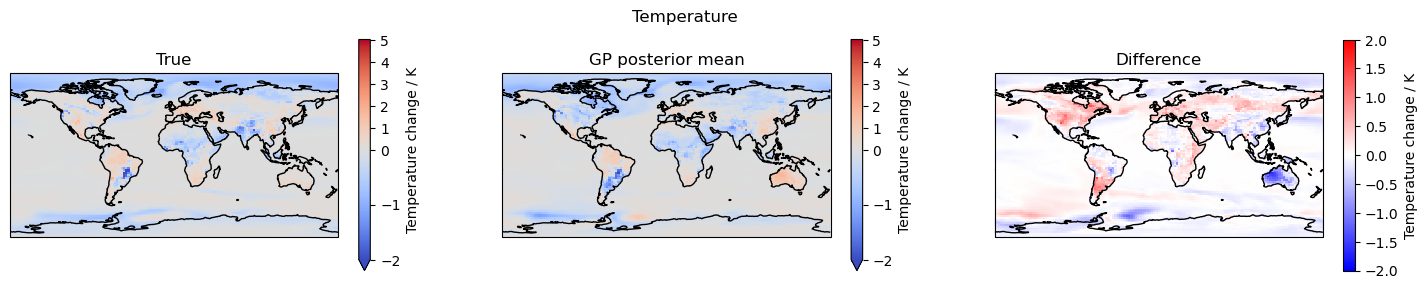

In [14]:
# plotting predictions
divnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=5)
diffnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=2)

## Temperature
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(18, 3))
fig.suptitle('Temperature')

# Test
plt.subplot(131, projection=proj)
dtr_truth.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", norm=divnorm,
                              cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='True')

# Emulator
plt.subplot(132, projection=proj)
posterior_dtr_data.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", norm=divnorm,
                       cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='GP posterior mean')

# Difference
difference = dtr_truth - posterior_dtr_data
plt.subplot(133, projection=proj)
difference.sel(time=slice(2050,None)).mean('time').plot(cmap="bwr", norm=diffnorm,
                cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='Difference')

In [15]:
def global_mean(ds):
    if 'lat' not in ds.coords:
        ds_ = ds.rename({'latitude': 'lat', 'longitude': 'lon'})
    else:
        ds_ = ds
    weights = np.cos(np.deg2rad(ds_.lat))
    return ds_.weighted(weights).mean(['lat', 'lon'])

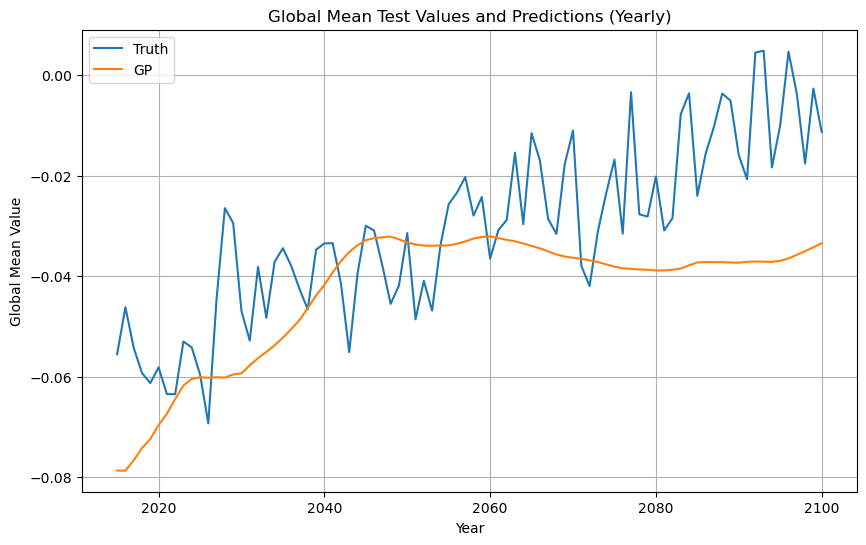

In [16]:
# t = xr.open_dataarray('climatebench-gp-posterior-mean-dtr-test-2019-2100.nc')
plt.figure(figsize=(10, 6))
global_mean(dtr_truth).plot(label="Truth")
global_mean(posterior_dtr_data).plot(label='GP')
# global_mean(t).plot(label='from repo')
plt.title('Global Mean Test Values and Predictions (Yearly)')
plt.ylabel('Global Mean Value')
plt.xlabel('Year')
plt.legend()
plt.grid(True)
plt.show()

## Hyperparams Tuning

In [17]:
from ray import tune, train
from ray.tune.search.hyperopt import HyperOptSearch
from gpflow.kernels import Matern12, Matern32, Matern52, SquaredExponential, RationalQuadratic, Cosine, Periodic, Polynomial, ArcCosine, Exponential
import keras
import math
from gpflow.mean_functions import Constant
from xskillscore import rmse
from ray.tune import CLIReporter
import ray

In [18]:
ray.init(num_cpus=1, num_gpus=1)

2024-03-05 01:46:24,481	INFO worker.py:1724 -- Started a local Ray instance.


Python version:,3.9.18
Ray version:,2.9.3


In [19]:
def get_rmse(truth, pred):
    return np.sqrt(((truth-pred)**2))

def global_mean(ds):
    weights = np.cos(np.deg2rad(ds.lat))
    return ds.weighted(weights).mean(['lat', 'lon'])

def global_sum(ds):
    weights = np.cos(np.deg2rad(ds.lat))
    return ds.weighted(weights).sum(['lat', 'lon'])

weights = np.cos(np.deg2rad(dtr_truth.lat)).expand_dims(lon=144).assign_coords(lon=dtr_truth.lon)
    
def TNRMSE(truth, pred, Yearslice=slice(2080, None)):
    # R2E Score
    R2E = rmse(
        global_mean(truth.sel(time=Yearslice)), 
        global_mean(pred.sel(time=Yearslice))
    ).data/np.abs(global_mean(truth.sel(time=Yearslice).mean('time')).data)

    # NRMSE score
    NRMSE = rmse(
        truth.sel(time=Yearslice).mean('time'), 
        pred.sel(time=Yearslice).mean('time'), weights=weights
    ).data/ np.abs(global_mean(truth.sel(time=Yearslice).mean('time')).data)

    total = (NRMSE + 5*R2E).T.round(3)
    return total

In [20]:
def make_feature_extractor(dim_max, activation, input_dim, output_dim, dropout_prob, bnorm=True, dropout=True):
    model = tf.keras.Sequential()
    model.add(keras.layers.InputLayer(input_shape=(input_dim,)))
    
    dimensions = [dim_max // (2 ** i) for i in range(int(math.log(dim_max, 2)) + 1) if dim_max // (2 ** i) > input_dim]

    for dim in dimensions[::-1]:
        model.add(keras.layers.Dense(dim, activation=activation))
        if bnorm:
            model.add(keras.layers.BatchNormalization())
        if dropout:
            model.add(keras.layers.Dropout(dropout_prob))

    for dim in dimensions:
        if dim <= output_dim:
            break
        model.add(keras.layers.Dense(dim, activation=activation))
        if bnorm:
            model.add(keras.layers.BatchNormalization())
        if dropout:
            model.add(keras.layers.Dropout(dropout_prob))

    model.add(keras.layers.Dense(output_dim, activation='linear'))
    model.add(keras.layers.Lambda(lambda x: tf.cast(x, tf.float64)))
        
    return model

In [21]:
def basekernel(kernel_types, active_dim_multiplier, variance=1.0, lengthscales=1.0):
    kernels = {
        'Matern12': Matern12, 'Matern32': Matern32, 'Matern52': Matern52, 'SquaredExponential': SquaredExponential, 'RationalQuadratic': RationalQuadratic, 'Cosine':Cosine, 'Periodic': Periodic,
        'Polynomial': Polynomial, 'ArcCosine': ArcCosine, 'Exponential': Exponential
    }
    dims = [x for x in range(12*active_dim_multiplier)]
    def CO2(kernel):
        active_dims = dims[0:active_dim_multiplier*1]
        k = kernel(active_dims = active_dims, variance=variance, lengthscales=(1*active_dim_multiplier) * [1.])
        return k

    def CH4(kernel):
        active_dims = dims[1*active_dim_multiplier:active_dim_multiplier*2]
        k = kernel(active_dims = active_dims, variance=variance, lengthscales=(1*active_dim_multiplier) * [1.])
        return k
        
    def BC(kernel):
        active_dims = dims[2*active_dim_multiplier:active_dim_multiplier*2 + 5*active_dim_multiplier]
        k = kernel(active_dims = active_dims, variance=variance, lengthscales=(5*active_dim_multiplier) * [1.])
        return k

    def SO2(kernel):
        active_dims = dims[active_dim_multiplier*2 + 5*active_dim_multiplier:]
        k = kernel(active_dims = active_dims, variance=variance, lengthscales=(5*active_dim_multiplier) * [1.])
        return k
    
    kernel = CO2(kernels[kernel_types[0]]) + CH4(kernels[kernel_types[1]]) + BC(kernels[kernel_types[2]]) + SO2(kernels[kernel_types[3]])

    return kernel

In [22]:
def objective(config, return_pred=False):  # ①
    input_dim = X_train.shape[1]  # Number of features in X
    
    output_dim = config["output_dim"]
    # Feature extractor for deep kernel
    feature_extractor = make_feature_extractor(
        config["dim_max"], config["activation"], input_dim, config["output_dim"], config["dropout_prob"], bnorm=config["bnorm"], dropout=config["dropout"]
    )
    
    # Freeze the neural network layers to make them non-trainable in GPflow's optimization process
    for layer in feature_extractor.layers:
        layer.trainable = True
    
    # Define kernel
    base_kernel = basekernel(
        config["kernel_types"], config["active_dim_multiplier"]
    )
    deep_kernel = DeepKernel(feature_extractor=feature_extractor, base_kernel=base_kernel, input_dim=input_dim)

    mean_function = Constant() # Define Mean function

    optimizer  = tf.keras.optimizers.Adam(learning_rate=config["optimizer_lr"])# Define opt

    model = gpflow.models.GPR(data=(X_train.astype(float), y_train_dtr.astype(float)), kernel=deep_kernel, mean_function=mean_function)
    

    # custom optimizer
    @tf.function
    def optimization_step():
        with tf.GradientTape(watch_accessed_variables=False) as tape:
            tape.watch(model.trainable_variables)
            loss = -model.log_marginal_likelihood()
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        return loss


    # Training
    tolerance, patience = 1e-6, 10  # Define tolerance and patience

    # Initialize variables for early stopping mechanism
    best_loss, patience_counter, max_iterations = float('inf'), 0, 5000
    
    # Training loop
    for iteration in range(max_iterations):  # Number of optimization steps
        loss = optimization_step()
    
        # Early stopping logic
        if best_loss - loss < tolerance:
            patience_counter += 1
        else:
            patience_counter = 0
            best_loss = loss
    
        if patience_counter >= patience:
            print(f"Stopping training after {iteration + 1} iterations due to convergence.")
            break

    # Eval
    standard_posterior_mean, standard_posterior_var = model.predict_y(X_test.values)
    posterior_mean = standard_posterior_mean * train_dtr_std + train_dtr_mean
    posterior_std = np.sqrt(standard_posterior_var) * train_dtr_std

    # put output back into xarray format for calculating RMSE/plotting
    posterior_dtr = np.reshape(posterior_mean, [86, 96, 144])
    posterior_dtr_std = np.reshape(posterior_std, [86, 96, 144])
    
    posterior_dtr_data = xr.DataArray(posterior_dtr, dims=dtr_truth.dims, coords=dtr_truth.coords)
    posterior_dtr_std_data = xr.DataArray(posterior_dtr_std, dims=dtr_truth.dims, coords=dtr_truth.coords)

    total_NRMSE = TNRMSE(dtr_truth, posterior_dtr_data)

    if return_pred:
        return posterior_dtr_data, posterior_dtr_std_data


    return {'nrmse':total_NRMSE}

In [23]:
def run_tuner(search_space, num_samples=50):
    algo = HyperOptSearch()
    
    tuner = tune.Tuner(  # ③
        tune.with_resources(
            objective,
            resources={"cpu": 1, "gpu": 1}
        ),
        tune_config=tune.TuneConfig(
            metric="nrmse",
            mode="min",
            num_samples=num_samples,
            search_alg=algo,
        ),
        param_space=search_space,
    )

    results = tuner.fit()
    return results

In [24]:
search_space_2 = {
        "activation": tune.choice(["relu", "tanh", 'sigmoid']), "bnorm": tune.choice([True, False]), "dropout": tune.choice([True, False]), 'dropout_prob': tune.choice([0.5]),
        "kernel_types": tune.choice([4*['Matern32'], 4*['Matern12'], 4*['Matern52']]), "active_dim_multiplier": tune.choice([1, 2]), "dim_max": tune.choice([128, 256, 512]), 
        "output_dim": tune.choice([36, 48, 60, 72, 84]), "optimizer_lr": tune.choice([0.01, 0.001, 0.0001])
    }  # ②

search_space_1 = {
    "activation": tune.choice(["relu", "tanh", 'sigmoid']), "bnorm": tune.choice([True, False]), "dropout": tune.choice([True, False]), 'dropout_prob': tune.choice([0.5]),
    "kernel_types": tune.choice([4*['Matern32'], 4*['Matern12'], 4*['Matern52'], 4*['SquaredExponential']]), "active_dim_multiplier": tune.choice([1, 2]), "dim_max": tune.choice([128, 256, 64]), 
    "output_dim": tune.choice([12, 24, 36, 48, 60]), "optimizer_lr": tune.choice([0.01, 0.001])
} 

result = run_tuner(search_space_1)

(raylet) Warning: The actor ImplicitFunc is very large (35 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.


(pid=182455) 2024-03-05 01:50:35.821231: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=182455) 2024-03-05 01:50:35.821352: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=182455) 2024-03-05 01:50:35.822361: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=182455) 2024-03-05 01:50:35.830405: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
(pid=182455) To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate comp

(objective pid=182455) Stopping training after 831 iterations due to convergence.


(objective pid=182455) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14da78de2040> and will run it as-is.
(objective pid=182455) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=182455) Cause: Unknown node type <gast.gast.Import object at 0x14da78157700>
(objective pid=182455) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-05 01:51:13,252	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('SquaredExponential', 'SquaredExponential', 'SquaredExponential', 'SquaredExponential')}


(objective pid=182455) Stopping training after 972 iterations due to convergence.


(objective pid=182455) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14db8fd42d30> and will run it as-is.
(objective pid=182455) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=182455) Cause: Unknown node type <gast.gast.Import object at 0x14da780c7f10>
(objective pid=182455) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-05 01:51:18,583	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern32', 'Matern32', 'Matern32', 'Matern32')}


(objective pid=182455) Stopping training after 211 iterations due to convergence.


(objective pid=182455) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14db8fd425e0> and will run it as-is.
(objective pid=182455) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=182455) Cause: Unknown node type <gast.gast.Import object at 0x14db8fcd0520>
(objective pid=182455) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-05 01:51:26,262	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('SquaredExponential', 'SquaredExponential', 'SquaredExponential', 'SquaredExponential')}


(objective pid=182455) Stopping training after 526 iterations due to convergence.


(objective pid=182455) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14da1f7f6ee0> and will run it as-is.
(objective pid=182455) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=182455) Cause: Unknown node type <gast.gast.Import object at 0x14da0ca4d370>
(objective pid=182455) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(objective pid=182455) Stopping training after 216 iterations due to convergence.


2024-03-05 01:51:32,882	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern32', 'Matern32', 'Matern32', 'Matern32')}
(objective pid=182455) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14db8f067f70> and will run it as-is.
(objective pid=182455) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=182455) Cause: Unknown node type <gast.gast.Import object at 0x14da0c8fbca0>
(objective pid=182455) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-05 01:51:44,642	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern32', 'Matern32', 'Matern32', 'Matern32')}


(objective pid=182455) Stopping training after 945 iterations due to convergence.


(objective pid=182455) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14db8fd425e0> and will run it as-is.
(objective pid=182455) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=182455) Cause: Unknown node type <gast.gast.Import object at 0x14da0c0e7070>
(objective pid=182455) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-05 01:51:58,932	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern12', 'Matern12', 'Matern12', 'Matern12')}


(objective pid=182455) Stopping training after 1161 iterations due to convergence.


(objective pid=182455) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14da0c231940> and will run it as-is.
(objective pid=182455) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=182455) Cause: Unknown node type <gast.gast.Import object at 0x14da05beba60>
(objective pid=182455) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(objective pid=182455) 2024-03-05 01:52:11.000862: W external/local_tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 108.0KiB (rounded to 110592)requested by op Sum_4
(objective pid=182455) If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
(objective pid=182455) Current allocation summary follows.
(objective pid

(objective pid=183402) Stopping training after 511 iterations due to convergence.


(objective pid=183402) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14c0d0eb4430> and will run it as-is.
(objective pid=183402) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=183402) Cause: Unknown node type <gast.gast.Import object at 0x14bfc81e09a0>
(objective pid=183402) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-05 01:52:38,526	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('SquaredExponential', 'SquaredExponential', 'SquaredExponential', 'SquaredExponential')}


(objective pid=183402) Stopping training after 179 iterations due to convergence.


(objective pid=183402) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14c0d0eb4430> and will run it as-is.
(objective pid=183402) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=183402) Cause: Unknown node type <gast.gast.Import object at 0x14bfb01ab3a0>
(objective pid=183402) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-05 01:52:44,828	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('SquaredExponential', 'SquaredExponential', 'SquaredExponential', 'SquaredExponential')}


(objective pid=183402) Stopping training after 228 iterations due to convergence.


(objective pid=183402) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14bfc9487700> and will run it as-is.
(objective pid=183402) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=183402) Cause: Unknown node type <gast.gast.Import object at 0x14bfb00ef070>
(objective pid=183402) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-05 01:52:57,316	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern12', 'Matern12', 'Matern12', 'Matern12')}


(objective pid=183402) Stopping training after 927 iterations due to convergence.


(objective pid=183402) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14bfb00e91f0> and will run it as-is.
(objective pid=183402) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=183402) Cause: Unknown node type <gast.gast.Import object at 0x14bf34dec9d0>
(objective pid=183402) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(objective pid=183402) Stopping training after 208 iterations due to convergence.


2024-03-05 01:53:04,616	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 0.594 s, which may be a performance bottleneck.
2024-03-05 01:53:04,618	WARNING util.py:202 -- The `process_trial_result` operation took 0.596 s, which may be a performance bottleneck.
2024-03-05 01:53:04,619	WARNING util.py:202 -- Processing trial results took 0.597 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-03-05 01:53:04,620	WARNING util.py:202 -- The `process_trial_result` operation took 0.598 s, which may be a performance bottleneck.
2024-03-05 01:53:04,623	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern32', 'Matern32', 'Matern32', 'Matern32')}
(objective pid=183402) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14bf3536f1f0> and will run it as-is.
(objective pid=183402) Please report this t

(objective pid=183402) Stopping training after 950 iterations due to convergence.


(objective pid=183402) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14bfc8e2df70> and will run it as-is.
(objective pid=183402) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=183402) Cause: Unknown node type <gast.gast.Import object at 0x14bf346ec670>
(objective pid=183402) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-05 01:53:32,162	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('SquaredExponential', 'SquaredExponential', 'SquaredExponential', 'SquaredExponential')}


(objective pid=183402) Stopping training after 1219 iterations due to convergence.


(objective pid=183402) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14bf343e6f70> and will run it as-is.
(objective pid=183402) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=183402) Cause: Unknown node type <gast.gast.Import object at 0x14bee1c60e80>
(objective pid=183402) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-05 01:53:38,198	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('SquaredExponential', 'SquaredExponential', 'SquaredExponential', 'SquaredExponential')}


(objective pid=183402) Stopping training after 223 iterations due to convergence.


(objective pid=183402) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14bee1e29310> and will run it as-is.
(objective pid=183402) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=183402) Cause: Unknown node type <gast.gast.Import object at 0x14bee1827bb0>
(objective pid=183402) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(objective pid=183402) 2024-03-05 01:53:50.250429: W external/local_tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 62.02MiB (rounded to 65028096)requested by op gradient_tape/Mul_1
(objective pid=183402) If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
(objective pid=183402) Current allocation summary follows

(objective pid=184265) Stopping training after 670 iterations due to convergence.


(objective pid=184265) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x1476e47021f0> and will run it as-is.
(objective pid=184265) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=184265) Cause: Unknown node type <gast.gast.Import object at 0x1474f0c3c3a0>
(objective pid=184265) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-05 01:54:22,221	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern32', 'Matern32', 'Matern32', 'Matern32')}


(objective pid=184265) Stopping training after 221 iterations due to convergence.


(objective pid=184265) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x1476e4790700> and will run it as-is.
(objective pid=184265) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=184265) Cause: Unknown node type <gast.gast.Import object at 0x1474f257ab20>
(objective pid=184265) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-05 01:54:28,392	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('SquaredExponential', 'SquaredExponential', 'SquaredExponential', 'SquaredExponential')}


(objective pid=184265) Stopping training after 245 iterations due to convergence.


(objective pid=184265) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x1476e4790700> and will run it as-is.
(objective pid=184265) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=184265) Cause: Unknown node type <gast.gast.Import object at 0x1474f18c0070>
(objective pid=184265) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-05 01:54:36,626	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern52', 'Matern52', 'Matern52', 'Matern52')}


(objective pid=184265) Stopping training after 251 iterations due to convergence.


(objective pid=184265) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x1474f1832e50> and will run it as-is.
(objective pid=184265) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=184265) Cause: Unknown node type <gast.gast.Import object at 0x1474f130fbe0>
(objective pid=184265) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-05 01:54:49,598	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern52', 'Matern52', 'Matern52', 'Matern52')}


(objective pid=184265) Stopping training after 828 iterations due to convergence.


(objective pid=184265) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x1474f0e430d0> and will run it as-is.
(objective pid=184265) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=184265) Cause: Unknown node type <gast.gast.Import object at 0x1474f0b491f0>
(objective pid=184265) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(objective pid=184265) Stopping training after 989 iterations due to convergence.


2024-03-05 01:55:05,887	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern52', 'Matern52', 'Matern52', 'Matern52')}
(objective pid=184265) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x1474f0dda700> and will run it as-is.
(objective pid=184265) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=184265) Cause: Unknown node type <gast.gast.Import object at 0x1474f0328790>
(objective pid=184265) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-05 01:55:24,939	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern52', 'Matern52', 'Matern52', 'Matern52')}


(objective pid=184265) Stopping training after 1294 iterations due to convergence.


(objective pid=184265) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x1474f05a2430> and will run it as-is.
(objective pid=184265) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=184265) Cause: Unknown node type <gast.gast.Import object at 0x1474d5ce08e0>
(objective pid=184265) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(objective pid=184265) 2024-03-05 01:55:38.441266: W external/local_tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 62.02MiB (rounded to 65028096)requested by op gradient_tape/Mul_1
(objective pid=184265) If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
(objective pid=184265) Current allocation summary follows

(objective pid=185217) Stopping training after 16 iterations due to convergence.


(objective pid=185217) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x1504540f69d0> and will run it as-is.
(objective pid=185217) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=185217) Cause: Unknown node type <gast.gast.Import object at 0x1502e41e9dc0>
(objective pid=185217) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-05 01:56:16,605	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern52', 'Matern52', 'Matern52', 'Matern52')}


(objective pid=185217) Stopping training after 1236 iterations due to convergence.


(objective pid=185217) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x15045667bf70> and will run it as-is.
(objective pid=185217) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=185217) Cause: Unknown node type <gast.gast.Import object at 0x1502a59c4c40>
(objective pid=185217) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-05 01:56:23,643	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern52', 'Matern52', 'Matern52', 'Matern52')}


(objective pid=185217) Stopping training after 310 iterations due to convergence.


(objective pid=185217) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x1504566de1f0> and will run it as-is.
(objective pid=185217) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=185217) Cause: Unknown node type <gast.gast.Import object at 0x1502eef97700>
(objective pid=185217) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-05 01:56:43,567	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern52', 'Matern52', 'Matern52', 'Matern52')}


(objective pid=185217) Stopping training after 1290 iterations due to convergence.


(objective pid=185217) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x1502a4d4fee0> and will run it as-is.
(objective pid=185217) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=185217) Cause: Unknown node type <gast.gast.Import object at 0x1502a448b1c0>
(objective pid=185217) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-05 01:56:50,778	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern12', 'Matern12', 'Matern12', 'Matern12')}


(objective pid=185217) Stopping training after 361 iterations due to convergence.


(objective pid=185217) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x150455a24af0> and will run it as-is.
(objective pid=185217) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=185217) Cause: Unknown node type <gast.gast.Import object at 0x1502a4273160>
(objective pid=185217) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-05 01:57:08,558	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern52', 'Matern52', 'Matern52', 'Matern52')}


(objective pid=185217) Stopping training after 1160 iterations due to convergence.


(objective pid=185217) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x150249801820> and will run it as-is.
(objective pid=185217) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=185217) Cause: Unknown node type <gast.gast.Import object at 0x15024952db50>
(objective pid=185217) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-05 01:57:21,974	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern52', 'Matern52', 'Matern52', 'Matern52')}


(objective pid=185217) Stopping training after 808 iterations due to convergence.


(objective pid=185217) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x150249548820> and will run it as-is.
(objective pid=185217) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=185217) Cause: Unknown node type <gast.gast.Import object at 0x1502a441d8b0>
(objective pid=185217) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-05 01:57:30,288	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('SquaredExponential', 'SquaredExponential', 'SquaredExponential', 'SquaredExponential')}


(objective pid=185217) Stopping training after 345 iterations due to convergence.


(objective pid=185217) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x150330264d30> and will run it as-is.
(objective pid=185217) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=185217) Cause: Unknown node type <gast.gast.Import object at 0x150248849f40>
(objective pid=185217) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(objective pid=185217) 2024-03-05 01:57:43.454138: W external/local_tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 62.02MiB (rounded to 65028096)requested by op gradient_tape/Mul_1
(objective pid=185217) If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
(objective pid=185217) Current allocation summary follows

(objective pid=186234) Stopping training after 907 iterations due to convergence.


(objective pid=186234) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x143c271695e0> and will run it as-is.
(objective pid=186234) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=186234) Cause: Unknown node type <gast.gast.Import object at 0x143aeff4e6a0>
(objective pid=186234) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-05 01:58:26,132	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('SquaredExponential', 'SquaredExponential', 'SquaredExponential', 'SquaredExponential')}


(objective pid=186234) Stopping training after 836 iterations due to convergence.


(objective pid=186234) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x143b00cbbe50> and will run it as-is.
(objective pid=186234) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=186234) Cause: Unknown node type <gast.gast.Import object at 0x143b00458190>
(objective pid=186234) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-05 01:58:33,024	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern52', 'Matern52', 'Matern52', 'Matern52')}


(objective pid=186234) Stopping training after 281 iterations due to convergence.


(objective pid=186234) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x143aa8c17e50> and will run it as-is.
(objective pid=186234) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=186234) Cause: Unknown node type <gast.gast.Import object at 0x143aa1e956a0>
(objective pid=186234) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-05 01:58:48,007	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('SquaredExponential', 'SquaredExponential', 'SquaredExponential', 'SquaredExponential')}


(objective pid=186234) Stopping training after 953 iterations due to convergence.


(objective pid=186234) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x143b00c20ee0> and will run it as-is.
(objective pid=186234) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=186234) Cause: Unknown node type <gast.gast.Import object at 0x143aa17d4c10>
(objective pid=186234) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-05 01:59:04,777	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern32', 'Matern32', 'Matern32', 'Matern32')}


(objective pid=186234) Stopping training after 1201 iterations due to convergence.


(objective pid=186234) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x143aa1a2d820> and will run it as-is.
(objective pid=186234) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=186234) Cause: Unknown node type <gast.gast.Import object at 0x143aa0fecfd0>
(objective pid=186234) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-05 01:59:17,339	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('SquaredExponential', 'SquaredExponential', 'SquaredExponential', 'SquaredExponential')}


(objective pid=186234) Stopping training after 728 iterations due to convergence.


(objective pid=186234) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x143aa1280dc0> and will run it as-is.
(objective pid=186234) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=186234) Cause: Unknown node type <gast.gast.Import object at 0x143aa08d3340>
(objective pid=186234) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-05 01:59:34,368	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern12', 'Matern12', 'Matern12', 'Matern12')}


(objective pid=186234) Stopping training after 1267 iterations due to convergence.


(objective pid=186234) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x143aa0a1a280> and will run it as-is.
(objective pid=186234) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=186234) Cause: Unknown node type <gast.gast.Import object at 0x143aa011c100>
(objective pid=186234) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(objective pid=186234) 2024-03-05 01:59:48.031045: W external/local_tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 62.02MiB (rounded to 65028096)requested by op gradient_tape/Mul_1
(objective pid=186234) If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
(objective pid=186234) Current allocation summary follows

(objective pid=187200) Stopping training after 933 iterations due to convergence.


(objective pid=187200) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14dd6292c160> and will run it as-is.
(objective pid=187200) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=187200) Cause: Unknown node type <gast.gast.Import object at 0x14ded4418490>
(objective pid=187200) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-05 02:00:55,450	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern32', 'Matern32', 'Matern32', 'Matern32')}


(objective pid=187200) Stopping training after 1060 iterations due to convergence.


(objective pid=187200) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14ded40b9f70> and will run it as-is.
(objective pid=187200) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=187200) Cause: Unknown node type <gast.gast.Import object at 0x14debc065550>
(objective pid=187200) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-05 02:01:08,112	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern12', 'Matern12', 'Matern12', 'Matern12')}


(objective pid=187200) Stopping training after 1011 iterations due to convergence.


(objective pid=187200) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14dd49e3cb80> and will run it as-is.
(objective pid=187200) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=187200) Cause: Unknown node type <gast.gast.Import object at 0x14dd49158fd0>
(objective pid=187200) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-05 02:01:21,465	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('SquaredExponential', 'SquaredExponential', 'SquaredExponential', 'SquaredExponential')}


(objective pid=187200) Stopping training after 859 iterations due to convergence.


(objective pid=187200) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14dd48704f70> and will run it as-is.
(objective pid=187200) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=187200) Cause: Unknown node type <gast.gast.Import object at 0x14dd48a373d0>
(objective pid=187200) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-05 02:01:41,260	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern32', 'Matern32', 'Matern32', 'Matern32')}


(objective pid=187200) Stopping training after 1683 iterations due to convergence.


(objective pid=187200) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14dd49260670> and will run it as-is.
(objective pid=187200) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=187200) Cause: Unknown node type <gast.gast.Import object at 0x14dd4834a5e0>
(objective pid=187200) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-05 02:01:51,792	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern52', 'Matern52', 'Matern52', 'Matern52')}


(objective pid=187200) Stopping training after 708 iterations due to convergence.


(objective pid=187200) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14dd49095040> and will run it as-is.
(objective pid=187200) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=187200) Cause: Unknown node type <gast.gast.Import object at 0x14dd41dacfa0>
(objective pid=187200) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-05 02:02:04,771	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('SquaredExponential', 'SquaredExponential', 'SquaredExponential', 'SquaredExponential')}


(objective pid=187200) Stopping training after 826 iterations due to convergence.


(objective pid=187200) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14dd482f4790> and will run it as-is.
(objective pid=187200) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=187200) Cause: Unknown node type <gast.gast.Import object at 0x14dd417e6880>
(objective pid=187200) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-05 02:02:15,923	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern12', 'Matern12', 'Matern12', 'Matern12')}


(objective pid=187200) Stopping training after 932 iterations due to convergence.


2024-03-05 02:02:15,957	ERROR tune.py:1038 -- Trials did not complete: [objective_d7bc0410, objective_8e20444d, objective_44b600fe, objective_ff1022f7, objective_749aa50e]
2024-03-05 02:02:15,958	INFO tune.py:1042 -- Total run time: 702.72 seconds (702.54 seconds for the tuning loop).


In [25]:
best_config = result.get_best_result()
hyperparam_df = result.get_dataframe()
hyperparam_df_sorted = hyperparam_df.sort_values(by='nrmse')

In [26]:
mean_best, std_best = objective(best_config.config, return_pred=True)

Stopping training after 964 iterations due to convergence.


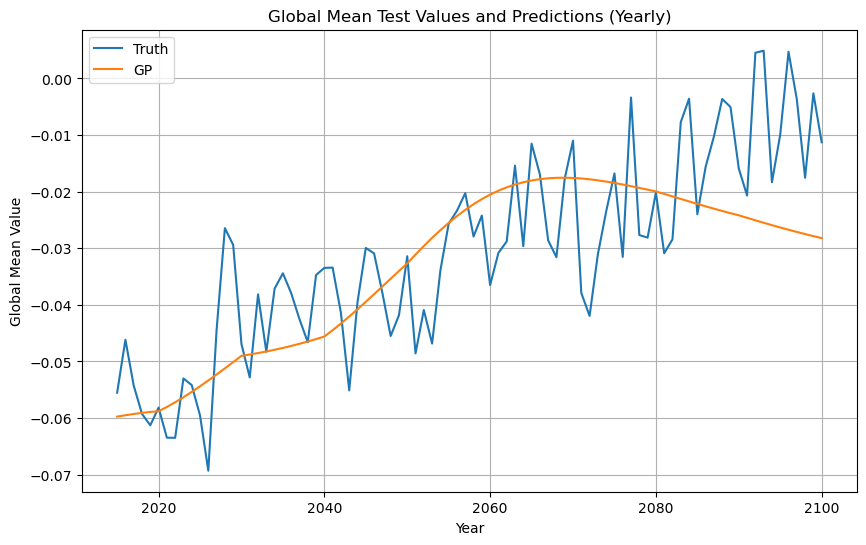

In [28]:
plt.figure(figsize=(10, 6))
global_mean(dtr_truth).plot(label="Truth")
global_mean(mean_best).plot(label='GP')
plt.title('Global Mean Test Values and Predictions (Yearly)')
plt.ylabel('Global Mean Value')
plt.xlabel('Year')
plt.legend()
plt.grid(True)
plt.show()

[Text(0.5, 1.0, 'Difference')]

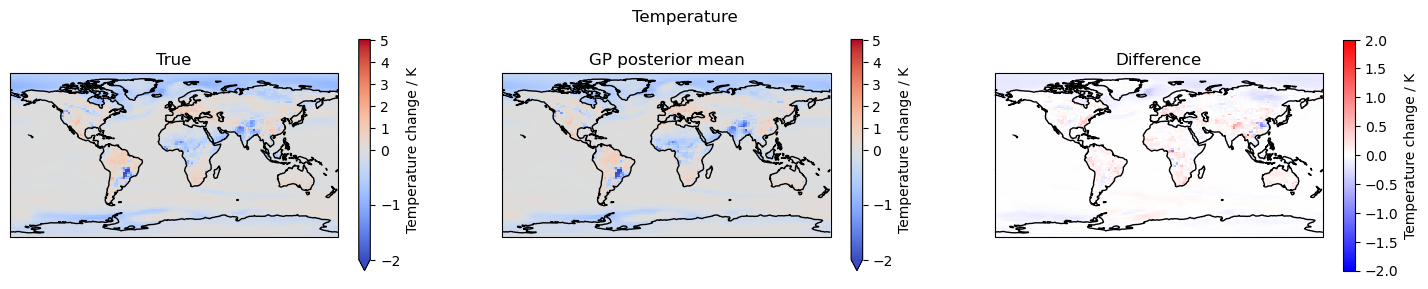

In [30]:
# plotting predictions
divnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=5)
diffnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=2)

## Temperature
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(18, 3))
fig.suptitle('Temperature')

# Test
plt.subplot(131, projection=proj)
dtr_truth.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", norm=divnorm,
                              cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='True')

# Emulator
plt.subplot(132, projection=proj)
mean_best.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", norm=divnorm,
                       cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='GP posterior mean')

# Difference
difference = dtr_truth - mean_best
plt.subplot(133, projection=proj)
difference.sel(time=slice(2050,None)).mean('time').plot(cmap="bwr", norm=diffnorm,
                cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='Difference')

In [37]:
TNRMSE(dtr_truth, mean_best, Yearslice=slice(2080, 2100))

16.287

In [38]:
mean_best.to_netcdf('results/Final-dkl-mean-dtr.nc')
std_best.to_netcdf('results/Final-dkl-std-dtr.nc')

In [39]:
best_config.config

{'activation': 'sigmoid',
 'bnorm': True,
 'dropout': False,
 'dropout_prob': 0.5,
 'kernel_types': ('Matern52', 'Matern52', 'Matern52', 'Matern52'),
 'active_dim_multiplier': 2,
 'dim_max': 256,
 'output_dim': 60,
 'optimizer_lr': 0.001}